# An Introduction to Bayesian Optimization II: Utility Functions and Gaussian Process Kernels

_Prepared by Ritz Aguilar for Thrill Summer School at Toulon, France, October 2024_

#### Objectives
- Differentiate the effects of using different utility/acquistion functions for BO.
- Use varying kernels for the Gaussian Process, e.g. Constant, Matern, RBF, etc.

### Exercise 1: Utility Functions

**Utility functions**, a.k.a. acquisition functions, guide the selection of the next point to evaluate in a black-box optimization problem. They balance two completing goals:
- _Exploration_: Searches unknown regions of the input space where the objective function has high uncertainty
- _Exploitation_: Focuses on regions where the model predicts high values based on the knowledge it has gathered so far.
    

*__Recall__*: In Bayesian Optimization (BO), a surrogate model (often a Gaussian Process) is fitted to the known data points -- evaluations of the objective function. This model provides both:
- A _mean prediction_, which is the model's estimate of the objective function at any given point.
- A _variance_ or _uncertainty estimate_, representing the confidence the model has in its prediction.

The acquisition (or utility) function uses these predictions to decide the next point to evaluate by assigning a score (utility value) to each possible point. The point with the highest score is selected as the next one to query.

#### Examples of Commonly-used Utility Functions:

1. **Expected Improvement (EI)**: Measures the expected amount of improvement over the best-observed value so far, balancing both uncertainty and the predicted value. Points with high potential for improvement are favored. The function is given by: $$-\text{EI}(x) = -\mathbb{E} [f(x) - f(\hat{x})].$$ _Note: A full implementation of this is found in Notebook Part I._

2. **Upper Confidence Bound (UCB)**: Incorporates both the mean and uncertainty by using a confidence bound to prioritize points with either high predicted values or high uncertainty. It is given by: $$\text{UCB}(x) = \mu_{GP}(x) + \kappa \sigma_{GP}(x).$$

3. **Probability of Improvement (PI)**: Measures the probability that a given point will improve over the current best value. It is given by: $$-\text{PI}(x) = -P(f(x) \geq f(\hat{x}) + \kappa).$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm

np.random.seed(42)

In [2]:
sns.set_style("ticks")
sns.set_context("notebook")

from plotting_utils import plot_prediction, plot_convergence
from bo_utils import expected_improvement

# Objective function with noise
noise_level = 0.05
def f(x, noise_level=noise_level):
    return -np.exp(-x) * np.sin(4 * x) + np.random.randn(*x.shape) * noise_level

# Define input range for plotting the objective function f
bounds = np.array([[-2.0, 2.0]])
X = np.linspace(bounds[:, 0], bounds[:, 1], 100).reshape(-1, 1)
Y = f(X, noise_level=0)

# Initial samples
X_init = np.random.uniform(bounds[:, 0], bounds[:, 1], 3).reshape(-1, 1)
Y_init = f(X_init)

# Kernel: Matern kernel for GP
kern_cm = C(1.0) * Matern(length_scale=1.0, nu=2.5)

# Gaussian Process model
gp = GaussianProcessRegressor(kernel=kern_cm, n_restarts_optimizer=9, alpha=noise_level**2, random_state=42)

In [3]:
def upper_confidence_bound(X, gp, kappa=2.576):
    mu, sigma = gp.predict(X, return_std=True)
    return mu + kappa * sigma

def probability_of_improvement(X, X_train, Y_train, gp, xi=0.01):
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(gp.predict(X_train))
    Z = (mu - mu_sample_opt - xi) / sigma
    return norm.cdf(Z)

#### Key Concept

The utility function is what transforms the BO process from a passive fitting of the objective function to an active search strategy. It enables efficient exploration of the search space while avoiding unnecessary evaluations, especially in expensive-to-evaluate problems.

In [4]:
# Adjust to pass the right number of arguments based on the utility function used
def suggest_next_sample(utility, X_train, Y_train, gp, bounds, n_restarts=25):
    dim = X_train.shape[1]
    min_val = 1
    min_x = None
    
    # Check if utility function requires X_train and Y_train
    if utility.__name__ in ['expected_improvement', 'probability_of_improvement']:
        def min_obj(X):
            return -utility(X.reshape(-1, dim), X_train, Y_train, gp).flatten()
    else:  # For UCB, only X and gp are needed
        def min_obj(X):
            return -utility(X.reshape(-1, dim), gp).flatten()
    
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    return min_x.reshape(-1, 1)

In [5]:
# Update to include title for viz purposes
def plot_utility(ax, X, Y, X_next, title='', show_legend=False):
    """
    Plot the utility (acquisition) function and the next proposed sampling point.
    """
    ax.clear()  # Clear the current axes before plotting
    ax.plot(X, Y, 'r-', lw=2, label='utility function')
    ax.fill_between(X.ravel(), Y.ravel(), color='red', alpha=0.3)
    ax.axvline(x=X_next, ls='--', c='k', lw=2, label='next sampling point')
    ax.set_title(title)
    # ax.set_xlim([bounds[:,0], bounds[:,1]])
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    
    if show_legend:
        ax.legend(loc="upper left")


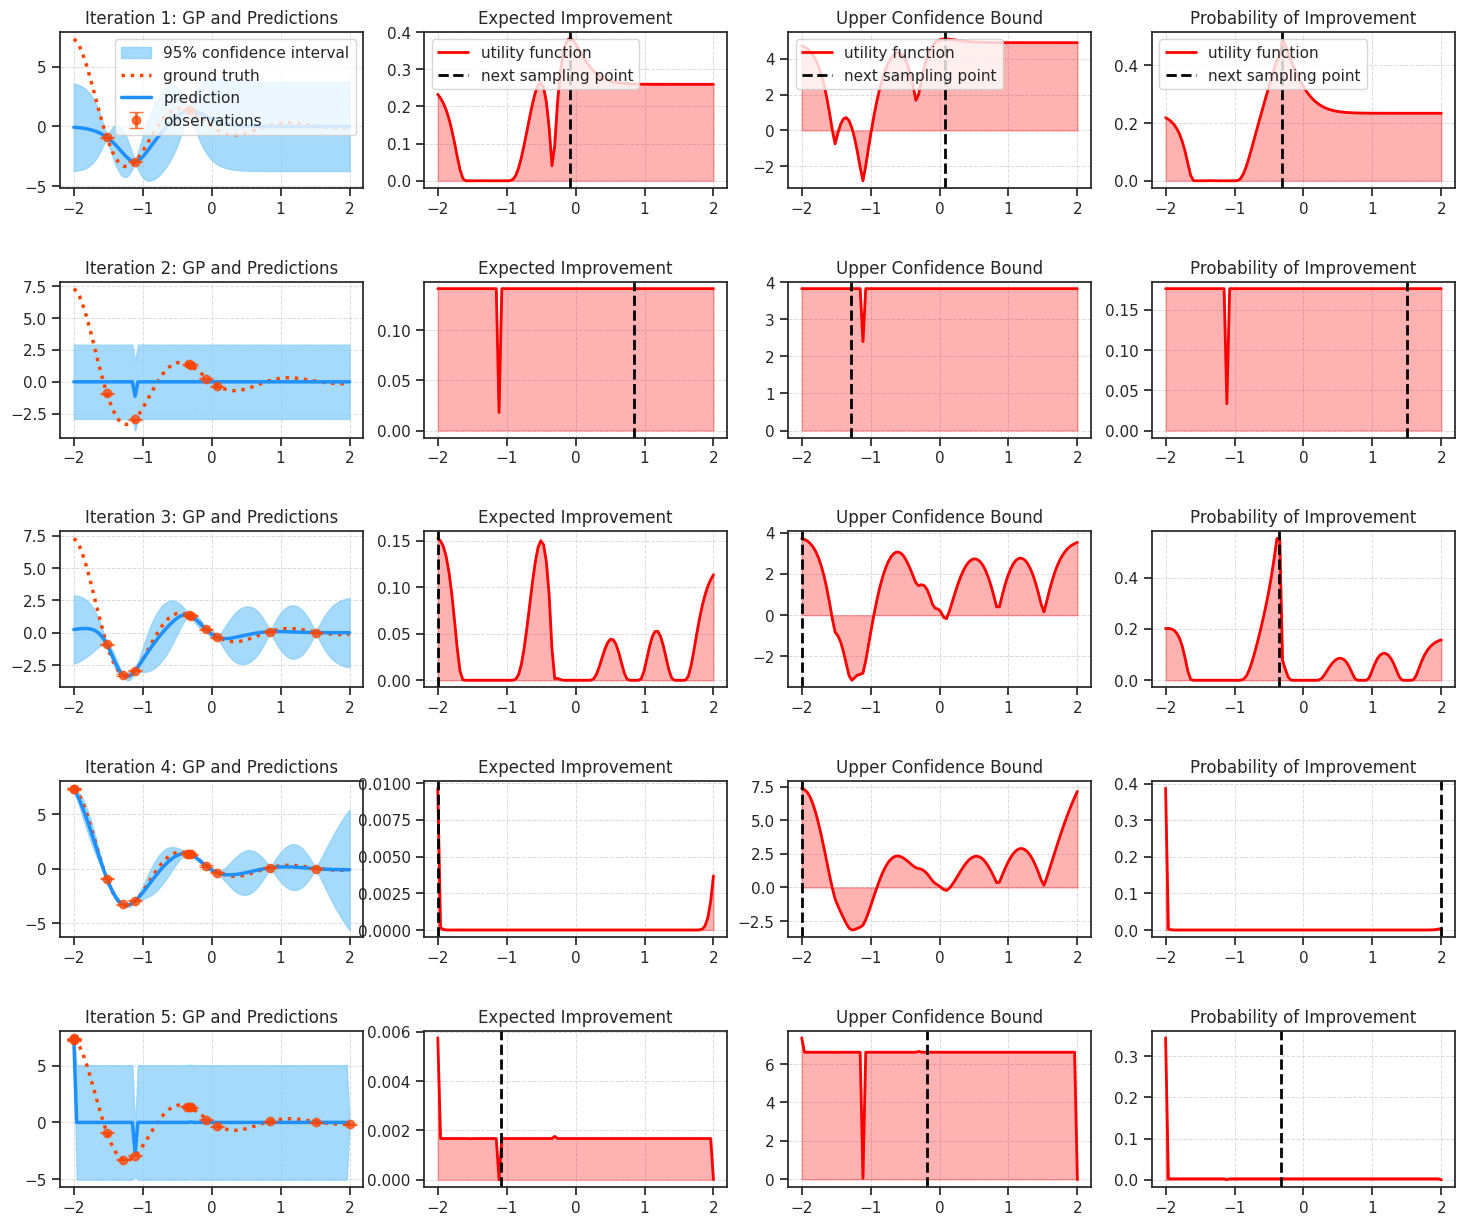

In [6]:
n_iter = 5
utility_functions = {
    'EI': expected_improvement, 
    'UCB': upper_confidence_bound, 
    'PI': probability_of_improvement
}

# Create a plot grid for comparison
fig, axes = plt.subplots(n_iter, 4, figsize=(18, n_iter * 3))
plt.subplots_adjust(hspace=0.6)

X_train = X_init
Y_train = Y_init

for i in range(n_iter):
    gp.fit(X_train, Y_train)
    
    X_next_ei = suggest_next_sample(expected_improvement, X_train, Y_train, gp, bounds)
    X_next_ucb = suggest_next_sample(upper_confidence_bound, X_train, Y_train, gp, bounds)
    X_next_pi = suggest_next_sample(probability_of_improvement, X_train, Y_train, gp, bounds)
    
    Y_next_ei = f(X_next_ei, noise_level)
    Y_next_ucb = f(X_next_ucb, noise_level)
    Y_next_pi = f(X_next_pi, noise_level)
    
    # Plot the GP approximation, noisy samples, and the next sampling points
    plot_prediction(axes[i, 0], gp, X, Y, X_train, Y_train, None, noise_level=noise_level, show_legend=(i == 0))
    axes[i, 0].set_title(f'Iteration {i + 1}: GP and Predictions')

    # Plot Expected Improvement
    ei_values = expected_improvement(X, X_train, Y_train, gp)
    plot_utility(axes[i, 1], X, ei_values, X_next_ei, show_legend=(i == 0))
    axes[i, 1].set_title('Expected Improvement')

    # Plot Upper Confidence Bound
    ucb_values = upper_confidence_bound(X, gp)
    plot_utility(axes[i, 2], X, ucb_values, X_next_ucb, show_legend=(i == 0))
    axes[i, 2].set_title('Upper Confidence Bound')

    # Plot Probability of Improvement
    pi_values = probability_of_improvement(X, X_train, Y_train, gp)
    plot_utility(axes[i, 3], X, pi_values, X_next_pi, show_legend=(i == 0))
    axes[i, 3].set_title('Probability of Improvement')

    # Update training set with the next samples
    X_train = np.vstack((X_train, X_next_ei, X_next_ucb, X_next_pi))
    Y_train = np.vstack((Y_train, Y_next_ei, Y_next_ucb, Y_next_pi))

plt.show()


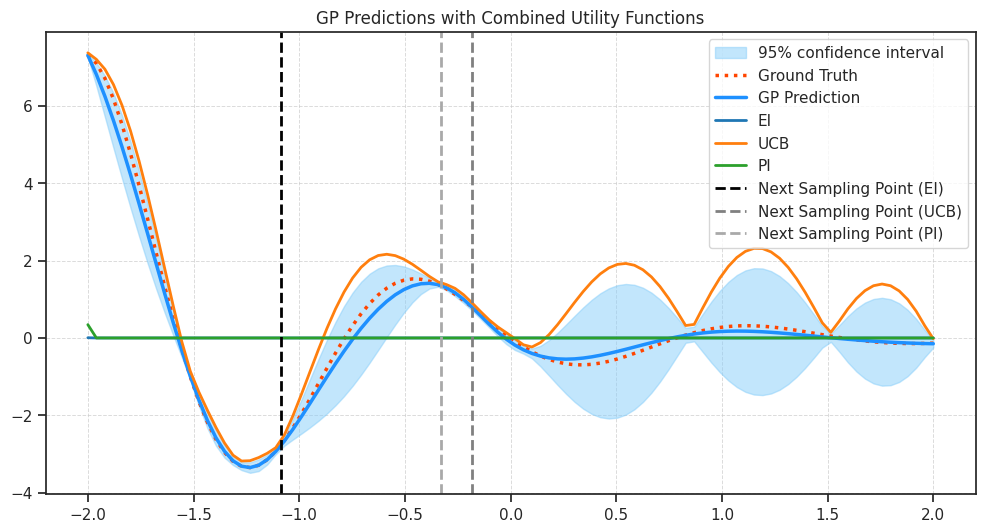

In [7]:
# Create a plot for GP predictions with combined utility functions
fig, ax = plt.subplots(figsize=(12, 6))

# Fit GP to the training data
gp.fit(X_train, Y_train)

# Make predictions
Y_pred, sigma = gp.predict(X, return_std=True)

# Plot GP predictions and confidence interval
ax.fill_between(X.ravel(), 
                Y_pred - 1.96 * sigma, 
                Y_pred + 1.96 * sigma, 
                color='#87CEFA', alpha=0.5, label='95% confidence interval')
ax.plot(X, Y, c='#FF4500', ls=':', lw=2.5, label='Ground Truth')
ax.plot(X, Y_pred, c='#1E90FF', lw=2.5, label='GP Prediction')

# Plot each utility function
utility_functions = {
    'EI': expected_improvement, 
    'UCB': upper_confidence_bound, 
    'PI': probability_of_improvement
}

# Prepare for utility function evaluation
for label, utility in utility_functions.items():
    if label == 'UCB':
        utility_values = utility(X, gp)  # Call with only X and gp
    else:
        utility_values = utility(X, X_train, Y_train, gp)  # Call with all four arguments

    ax.plot(X, utility_values, lw=2, label=label)

# Highlight the next sampling points
ax.axvline(x=X_next_ei, ls='--', c='k', lw=2, label='Next Sampling Point (EI)')
ax.axvline(x=X_next_ucb, ls='--', c='gray', lw=2, label='Next Sampling Point (UCB)')
ax.axvline(x=X_next_pi, ls='--', c='darkgray', lw=2, label='Next Sampling Point (PI)')

# Add legend and grid
ax.legend(loc="upper right")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.set_title('GP Predictions with Combined Utility Functions')
plt.show()


#### Exercise 1.1: Parameter Tuning

Tune the parameters $\xi$ and $\kappa$ for the utility functions and observe what happens. Which one is favored more (exploration or exploitation) when you increase/decrease the value? Write down your observations.

#### Some Output Characteristics

1. Expected Improvement (EI)
    - High values indicate regions where significant improvements over the best known sample are expected.
    - It balances exploration and exploitation by considering both the predicted mean and uncertainty.
    - EI tends to favor points where the model predicts high potential improvements, often leading to more aggressive sampling in regions that have previously yielded low results but with high uncertainty.


2. Upper Confidence Bound (UCB)

    - High UCB values suggest areas of high predicted mean plus uncertainty, encouraging exploration of uncertain regions.
    - UCB provides a more deterministic strategy compared to EI, as it emphasizes regions where the model predicts a high mean regardless of the uncertainty.
    
    
3. Probability of Improvement (PI)

    - Outputs a probability score between 0 and 1, where values closer to 1 indicate a high likelihood of improvement.
    - It can be less sensitive to the magnitude of potential improvement compared to EI, focusing solely on the probability rather than the expected value of that improvement.
    - PI tends to be more conservative, as it will favor points with a higher probability of improvement even if the expected gain is lower, making it suitable for scenarios where improvement certainty is crucial.

#### Summary

The utility function in BO is the mathematical function that helps decide where to sample next by assigning a score to each candidate point, balancing the tradeoff between exploration (uncertain areas) and exploitation (promising areas).

#### References

1. Brochu et al. (2010): A Tutorial on Bayesian Optimization
2. Rasmussen and Williams (2006): Gaussian Processes for Machine Learning
3. Srinivas et al. (2010): Gaussian Process Optimization in the Bandit Setting

### Exercise 2: Gaussian Process Kernels

Interactive visualizations:
    
1. [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)
2. [Interactive Gaussian Process Visualization](http://www.infinitecuriosity.org/vizgp/)